# Hello, _nbpresent_!

In [ ]:
import nbpresent
nbpresent.__version__

# Using Jupyter Notebook for Db2 Administration
&nbsp;&nbsp;&nbsp;&nbsp;Ember Crooks

&nbsp;&nbsp;&nbsp;&nbsp;XTIVIA

&nbsp;&nbsp;&nbsp;&nbsp;Session Code: F1

&nbsp;&nbsp;&nbsp;&nbsp;Wednesday, May 2 1:05 PM

## Setting up this Jupyter Notebook

This notebook should be launched from a session of jupyter notebook that was launched from a DB2 command window
To do this, run an administrator DB2 command window as an administrator and type 'jupyter notebook'

## Jupyter Notebook

### What is Jupyter Notebook?
- Open-source web application that allows you to create and share documents that contain live code, equations, visualizations, and explanatory text.
- Heavily used in Data Science
- Supports a large number of programming languages, including SQL
- Requires Python
- Easiest to install by [installing Anaconda](https://www.continuum.io/downloads)

### Jupyter Notebook Terms
- **Application**
    - Server-client application that allows editing and running notebook document via web browser
    - Can run on a local laptop/desktop or a remote server
- **Kernel**
    - Computational engine that execute the code contained in the notebook
    - ipython kernel executes python – kernels for other languages exist
    - Each running notebook has a different instnace of a Kernel
- **Notebook Dashboard**
    - Shown in browser when you launch Jupyter Notebook
    - Features similar to a file manager
    - Used to open notebooks and manage the running kernels

### More Jupyter Notebook Terms
- **Notebook document or notebooks**
    - Produced by the Jupyter Notebook App
    - Contains both computer code and rich text elements
- **Cell**
    - Portion of a notebook that is either markdown-formatted text or code
    - Each cell can be independently executed in any order, but convention dictates they be executed in order
- **Magic**
    - Called with a command line style syntax
    - Magic Functions work at the cell or line level

### Installing Jupyter Notebook on Windows
- [Download Anaconda](https://www.continuum.io/downloads)
- Install Anaconda, accepting the defaults
- Install at least a DB2 Client
- Download and install [visual studio tools](http://landinghub.visualstudio.com/visual-cpp-build-tools)

- Jupyter Notebook is likely to be installed on a DB2 client such as your laptop or a jump server

### Launching Jupyter Notebook on Windows
- Launch Jupyter Notebook from a DB2 Command Window PowerShell window with the Db2 environment variables set
- Cd to directory where Jupyter Notebooks are stored, first
![screenshot](files/LaunchJupyterNotebook.jpg)

### Jupyter Notebook Basics
[Basics of Jupyter Notebook](BasicsOfJupyterNotebook.ipynb)

### Setting up Jupyter Notebook for use with SQL Magic

#### Install Packages

In [ ]:
import sys,os,os.path
os.environ['DB2INSTANCE']

In [ ]:
## This cell only needs to be executed if these packages have not been previously installed
#Uncomment the below line and set to the proper value if installing these for the first time
#os.environ['IBM_DB_HOME']='C:\Program Files\IBM\SQLLIB_01'
!pip install ipython-sql
!pip install ibm_db 
!pip install ibm_db_sa

Restart the Kernel if this is your first time installing the above. The next steps will fail unless you do this.

#### Import the modules and load SQL magic

In [1]:
## This cell must be executed any time the Kernel is started or restarted
import ibm_db
import ibm_db_sa
import sqlalchemy
%load_ext sql

#### Connect to the database. 
- Change the values of user, host, and password to match your environment. 
- For connection to a local database, use 'localhost' for the host name. 
- Also change the port number and database name in the connection string.
- Minimally, the password is stored in a separate file for easier sharing

In [2]:
user='db2admin'
host='localhost'
# Define filename for passwords
filename = 'ember_variables.py'
# source the file
%run $filename
password = LocalDB2password

%sql db2+ibm_db://$user:$password@$host:50000/SAMPLE

'Connected: db2admin@SAMPLE'

Explicitly closing connections is not currently possible

### Using SQL in Jupyter Notebook 
- SQL magic makes SQL quick and easy
- DB2 commands can be executed when the notebook was launched from a command window, when prefixed with !
- Limited options available in sql magic - full ibm_db offers more options using Python or the core language of your choice

### Jupyter Notebook and SQL Magic Topics
- How does commit processing work by default and how can you change it?
- Using SQL magic for whole cell vs. line by line
- Displaying data in interesting ways
- Using host variables/parameter markers
- Explains

### Jupyter Notebook and Commit Processing
- Autocommit is on
- More advanced controls available through traditonal python syntax for the ibm_db driver

In [3]:
%sql drop table temp_sales
%sql create table temp_sales like ember.sales

Done.
Done.


[]

In [4]:
%sql insert into temp_sales select * from ember.sales

41 rows affected.


[]

In [5]:
%sql select count(*) from temp_sales

Done.


1
41


In [6]:
%sql insert into temp_sales select * from ember.sales
%sql rollback
%sql select count(*) from temp_sales

41 rows affected.
Done.
Done.


1
82


### Using SQL Magic at the Cell Level vs. the Line Level
- Line Level
    - Each line is prefixed with %
    - If a command fails, subsequent lines are still executed
- Cell Level
    - Using SQL Magic at the cell level involves starting a Cell with %%sql
    - All lines in the cell are then interpreted as SQL
    - If a command fails, subsequent lines are not executed

In [7]:
%%sql
--sql magic at the cell level
select * from syscat.tables;
select * from dual;
select * from syscat.bufferpools;

Done.
(ibm_db_dbi.ProgrammingError) ibm_db_dbi::ProgrammingError: SQLNumResultCols failed: [IBM][CLI Driver][DB2/NT64] SQL0204N  "DB2ADMIN.DUAL" is an undefined name.  SQLSTATE=42704\r SQLCODE=-204 [SQL: 'select * from dual;']


In [8]:
#sql magic at the line level
%sql select * from syscat.tables;
%sql select * from dual;
%sql select * from syscat.bufferpools;

Done.
(ibm_db_dbi.ProgrammingError) ibm_db_dbi::ProgrammingError: SQLNumResultCols failed: [IBM][CLI Driver][DB2/NT64] SQL0204N  "DB2ADMIN.DUAL" is an undefined name.  SQLSTATE=42704\r SQLCODE=-204 [SQL: 'select * from dual;']
Done.


bpname,bufferpoolid,dbpgname,npages,PAGESIZE,estore,numblockpages,blocksize,ngname
IBMDEFAULTBP,1,None,250,8192,N,0,0,None


### Displaying Data in Interesting Ways

In [9]:
#Import stuff we need
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import numpy as np
import pandas as pd

# All plots should be inline, inside the notebook
%matplotlib inline

Done.


([<matplotlib.patches.Wedge at 0x20a8f68c7f0>,
  <matplotlib.text.Text at 0x20a8f6e63c8>])

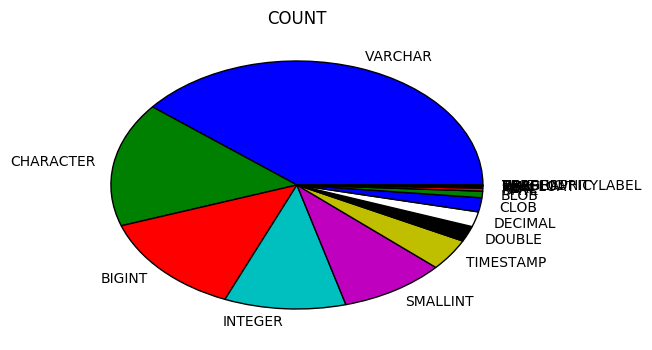

In [10]:
result= %sql select typename \
    , count(*) as count \
from syscat.columns \
group by typename \
order by count desc

result.pie()

In [11]:
%sql WITH SUM_TAB (SUM_RR, SUM_CPU, SUM_EXEC, SUM_SORT, SUM_NUM_EXEC) AS ( \
        SELECT  nullif(FLOAT(SUM(ROWS_READ)),0), \
                nullif(FLOAT(SUM(TOTAL_CPU_TIME)),0), \
                nullif(FLOAT(SUM(STMT_EXEC_TIME)),0), \
                nullif(FLOAT(SUM(TOTAL_SECTION_SORT_TIME)),0), \
                nullif(FLOAT(SUM(NUM_EXECUTIONS)),0) \
            FROM TABLE(MON_GET_PKG_CACHE_STMT ( 'D', NULL, NULL, -2)) AS T \
        ) \
SELECT \
        ROWS_READ, \
        DECIMAL(100*(FLOAT(ROWS_READ)/SUM_TAB.SUM_RR),5,2) AS PCT_TOT_RR, \
        TOTAL_CPU_TIME, \
        DECIMAL(100*(FLOAT(TOTAL_CPU_TIME)/SUM_TAB.SUM_CPU),5,2) AS PCT_TOT_CPU, \
        STMT_EXEC_TIME, \
        DECIMAL(100*(FLOAT(STMT_EXEC_TIME)/SUM_TAB.SUM_EXEC),5,2) AS PCT_TOT_EXEC, \
        TOTAL_SECTION_SORT_TIME, \
        DECIMAL(100*(FLOAT(TOTAL_SECTION_SORT_TIME)/SUM_TAB.SUM_SORT),5,2) AS PCT_TOT_SRT, \
        NUM_EXECUTIONS, \
        DECIMAL(100*(FLOAT(NUM_EXECUTIONS)/SUM_TAB.SUM_NUM_EXEC),5,2) AS PCT_TOT_EXEC, \
        DECIMAL(FLOAT(STMT_EXEC_TIME)/FLOAT(NUM_EXECUTIONS),10,2) AS AVG_EXEC_TIME, \
        RTRIM(STMT_TEXT) as STATEMENT \
    FROM TABLE(MON_GET_PKG_CACHE_STMT ( 'D', NULL, NULL, -2)) AS T, SUM_TAB \
    WHERE DECIMAL(100*(FLOAT(ROWS_READ)/SUM_TAB.SUM_RR),5,2) > 10 \
        OR DECIMAL(100*(FLOAT(TOTAL_CPU_TIME)/SUM_TAB.SUM_CPU),5,2) >10 \
        OR DECIMAL(100*(FLOAT(STMT_EXEC_TIME)/SUM_TAB.SUM_EXEC),5,2) >10 \
        OR DECIMAL(100*(FLOAT(TOTAL_SECTION_SORT_TIME)/SUM_TAB.SUM_SORT),5,2) >10 \
        OR DECIMAL(100*(FLOAT(NUM_EXECUTIONS)/SUM_TAB.SUM_NUM_EXEC),5,2) >10 \
    ORDER BY ROWS_READ DESC FETCH FIRST 20 ROWS ONLY WITH UR

Done.


rows_read,pct_tot_rr,total_cpu_time,pct_tot_cpu,stmt_exec_time,pct_tot_exec,total_section_sort_time,pct_tot_srt,num_executions,pct_tot_exec_1,avg_exec_time,STATEMENT
711,99.16,0,0.00,24,53.33,0,0.00,1,5.55,24.00,select * from syscat.tables
3,0.41,0,0.00,2,4.44,0,0.00,3,16.66,0.66,SELECT POLICY FROM SYSTOOLS.POLICY WHERE MED='DB2CommonMED' AND DECISION='NOP' AND NAME='CommonPolicy'
0,0.00,31250,100.00,18,40.00,2,100.00,1,5.55,18.00,"select typename , count(*) as count from syscat.columns group by typename order by count desc"
0,0.00,0,0.00,0,0.00,0,0.00,9,50.00,0.00,SET CURRENT LOCK TIMEOUT 5


In [12]:
result= %sql WITH SUM_TAB (SUM_RR, SUM_CPU, SUM_EXEC, SUM_SORT, SUM_NUM_EXEC) AS ( \
        SELECT  nullif(FLOAT(SUM(ROWS_READ)),0), \
                nullif(FLOAT(SUM(TOTAL_CPU_TIME)),0), \
                nullif(FLOAT(SUM(STMT_EXEC_TIME)),0), \
                nullif(FLOAT(SUM(TOTAL_SECTION_SORT_TIME)),0), \
                nullif(FLOAT(SUM(NUM_EXECUTIONS)),0) \
            FROM TABLE(MON_GET_PKG_CACHE_STMT ( 'D', NULL, NULL, -2)) AS T \
        ) \
SELECT substr(stmt_text,1,25) as STATEMENT, \
        ROWS_READ, \
        coalesce(DECIMAL(100*(FLOAT(ROWS_READ)/SUM_TAB.SUM_RR),5,2),0) AS PCT_TOT_RR, \
        TOTAL_CPU_TIME, \
        coalesce(DECIMAL(100*(FLOAT(TOTAL_CPU_TIME)/SUM_TAB.SUM_CPU),5,2),0) AS PCT_TOT_CPU, \
        STMT_EXEC_TIME, \
        coalesce(DECIMAL(100*(FLOAT(STMT_EXEC_TIME)/SUM_TAB.SUM_EXEC),5,2),0) AS PCT_TOT_EXEC, \
        TOTAL_SECTION_SORT_TIME, \
        coalesce(DECIMAL(100*(FLOAT(TOTAL_SECTION_SORT_TIME)/SUM_TAB.SUM_SORT),5,2),0) AS PCT_TOT_SRT, \
        NUM_EXECUTIONS, \
        coalesce(DECIMAL(100*(FLOAT(NUM_EXECUTIONS)/SUM_TAB.SUM_NUM_EXEC),5,2),0) AS PCT_TOT_EXECS, \
        DECIMAL(FLOAT(STMT_EXEC_TIME)/FLOAT(NUM_EXECUTIONS),10,2) AS AVG_EXEC_TIME, \
        RTRIM(STMT_TEXT) as FULL_STATEMENT \
    FROM TABLE(MON_GET_PKG_CACHE_STMT ( 'D', NULL, NULL, -2)) AS T, SUM_TAB \
    WHERE DECIMAL(100*(FLOAT(ROWS_READ)/SUM_TAB.SUM_RR),5,2) > 10 \
        OR DECIMAL(100*(FLOAT(TOTAL_CPU_TIME)/SUM_TAB.SUM_CPU),5,2) >10 \
        OR DECIMAL(100*(FLOAT(STMT_EXEC_TIME)/SUM_TAB.SUM_EXEC),5,2) >10 \
        OR DECIMAL(100*(FLOAT(TOTAL_SECTION_SORT_TIME)/SUM_TAB.SUM_SORT),5,2) >10 \
        OR DECIMAL(100*(FLOAT(NUM_EXECUTIONS)/SUM_TAB.SUM_NUM_EXEC),5,2) >10 \
    ORDER BY ROWS_READ DESC FETCH FIRST 20 ROWS ONLY WITH UR
%matplotlib inline
df=result.DataFrame()
df.describe()

Done.


,rows_read,total_cpu_time,stmt_exec_time,total_section_sort_time,num_executions
count,4.000000,4.000000,4.000000,4.0,4.0
mean,178.000000,11718.750000,13.500000,0.5,1.0
std,355.333646,14959.798559,10.246951,1.0,0.0
min,0.000000,0.000000,0.000000,0.0,1.0
25%,0.000000,0.000000,9.000000,0.0,1.0
50%,0.500000,7812.500000,15.000000,0.0,1.0
75%,178.500000,19531.250000,19.500000,0.5,1.0
max,711.000000,31250.000000,24.000000,2.0,1.0


Show number of rows and number of columns of the output

In [13]:
df.shape

(4, 13)

Show the names of all columns, in a comma separated list

In [14]:
df.columns

Index(['STATEMENT', 'rows_read', 'pct_tot_rr', 'total_cpu_time', 'pct_tot_cpu',
       'stmt_exec_time', 'pct_tot_exec', 'total_section_sort_time',
       'pct_tot_srt', 'num_executions', 'pct_tot_execs', 'avg_exec_time',
       'full_statement'],
      dtype='object')

Sort the output by a different column

In [15]:
# sort output by a different column
df.sort_values(by=['stmt_exec_time'], ascending=False)

,STATEMENT,rows_read,pct_tot_rr,total_cpu_time,pct_tot_cpu,stmt_exec_time,pct_tot_exec,total_section_sort_time,pct_tot_srt,num_executions,pct_tot_execs,avg_exec_time,full_statement
0,select * from syscat.tabl,711,99.85,0,0.00,24,44.44,0,0.00,1,25.00,24.00,select * from syscat.tables
3,"select typename , cou",0,0.00,31250,66.66,18,33.33,2,100.00,1,25.00,18.00,"select typename , count(*) as count from s..."
2,"WITH SUM_TAB (SUM_RR, SUM",0,0.00,15625,33.33,12,22.22,0,0.00,1,25.00,12.00,"WITH SUM_TAB (SUM_RR, SUM_CPU, SUM_EXEC, SUM_S..."
1,select * from syscat.buff,1,0.14,0,0.00,0,0.00,0,0.00,1,25.00,0.00,select * from syscat.bufferpools


Some data types may not be what is expected

In [16]:
df.dtypes

STATEMENT                  object
rows_read                   int64
pct_tot_rr                 object
total_cpu_time              int64
pct_tot_cpu                object
stmt_exec_time              int64
pct_tot_exec               object
total_section_sort_time     int64
pct_tot_srt                object
num_executions              int64
pct_tot_execs              object
avg_exec_time              object
full_statement             object
dtype: object

Convert incorrect columns to FLOAT

In [17]:
df[['pct_tot_rr']]=df[['pct_tot_rr']].astype(float)
df[['pct_tot_cpu']]=df[['pct_tot_cpu']].astype(float)
df[['pct_tot_exec']]=df[['pct_tot_exec']].astype(float)
df[['pct_tot_srt']]=df[['pct_tot_srt']].astype(float)
df[['pct_tot_execs']]=df[['pct_tot_execs']].astype(float)
df[['avg_exec_time']]=df[['avg_exec_time']].astype(float)

Verify the data type conversion worked

In [18]:
df.dtypes

STATEMENT                   object
rows_read                    int64
pct_tot_rr                 float64
total_cpu_time               int64
pct_tot_cpu                float64
stmt_exec_time               int64
pct_tot_exec               float64
total_section_sort_time      int64
pct_tot_srt                float64
num_executions               int64
pct_tot_execs              float64
avg_exec_time              float64
full_statement              object
dtype: object

Plot the data on multiple dimensions

<function matplotlib.pyplot.show>

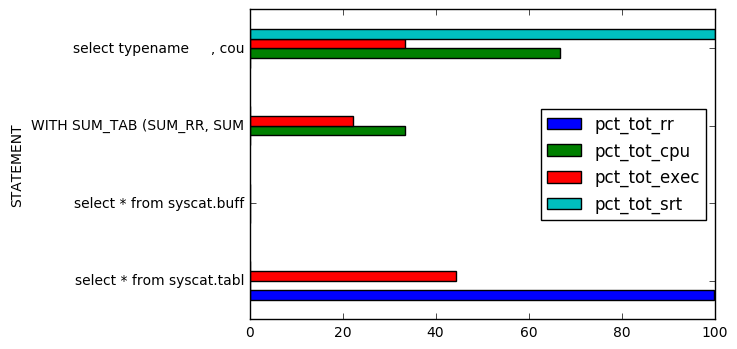

In [19]:
df.plot(x='STATEMENT', y=['pct_tot_rr','pct_tot_cpu','pct_tot_exec','pct_tot_srt'], kind='barh')
plt.show

In [20]:
pd.set_option('display.max_colwidth', -1)
df[['full_statement']]

,full_statement
0,select * from syscat.tables
1,select * from syscat.bufferpools
2,"WITH SUM_TAB (SUM_RR, SUM_CPU, SUM_EXEC, SUM_SORT, SUM_NUM_EXEC) AS ( SELECT nullif(FLOAT(SUM(ROWS_READ)),0), nullif(FLOAT(SUM(TOTAL_CPU_TIME)),0), nullif(FLOAT(SUM(STMT_EXEC_TIME)),0), nullif(FLOAT(SUM(TOTAL_SECTION_SORT_TIME)),0), nullif(FLOAT(SUM(NUM_EXECUTIONS)),0) FROM TABLE(MON_GET_PKG_CACHE_STMT ( 'D', NULL, NULL, -2)) AS T ) SELECT ROWS_READ, DECIMAL(100*(FLOAT(ROWS_READ)/SUM_TAB.SUM_RR),5,2) AS PCT_TOT_RR, TOTAL_CPU_TIME, DECIMAL(100*(FLOAT(TOTAL_CPU_TIME)/SUM_TAB.SUM_CPU),5,2) AS PCT_TOT_CPU, STMT_EXEC_TIME, DECIMAL(100*(FLOAT(STMT_EXEC_TIME)/SUM_TAB.SUM_EXEC),5,2) AS PCT_TOT_EXEC, TOTAL_SECTION_SORT_TIME, DECIMAL(100*(FLOAT(TOTAL_SECTION_SORT_TIME)/SUM_TAB.SUM_SORT),5,2) AS PCT_TOT_SRT, NUM_EXECUTIONS, DECIMAL(100*(FLOAT(NUM_EXECUTIONS)/SUM_TAB.SUM_NUM_EXEC),5,2) AS PCT_TOT_EXEC, DECIMAL(FLOAT(STMT_EXEC_TIME)/FLOAT(NUM_EXECUTIONS),10,2) AS AVG_EXEC_TIME, RTRIM(STMT_TEXT) as STATEMENT FROM TABLE(MON_GET_PKG_CACHE_STMT ( 'D', NULL, NULL, -2)) AS T, SUM_TAB WHERE DECIMAL(100*(FLOAT(ROWS_READ)/SUM_TAB.SUM_RR),5,2) > 10 OR DECIMAL(100*(FLOAT(TOTAL_CPU_TIME)/SUM_TAB.SUM_CPU),5,2) >10 OR DECIMAL(100*(FLOAT(STMT_EXEC_TIME)/SUM_TAB.SUM_EXEC),5,2) >10 OR DECIMAL(100*(FLOAT(TOTAL_SECTION_SORT_TIME)/SUM_TAB.SUM_SORT),5,2) >10 OR DECIMAL(100*(FLOAT(NUM_EXECUTIONS)/SUM_TAB.SUM_NUM_EXEC),5,2) >10 ORDER BY ROWS_READ DESC FETCH FIRST 20 ROWS ONLY WITH UR"
3,"select typename , count(*) as count from syscat.columns group by typename order by count desc"


### Using Host Variables / Parameter Markers

This statement is prepared using the literal value

In [21]:
check_id = 'DB2ADMIN'
%sql select tabschema \
    , tabname \
    , controlauth \
    , deleteauth \
    , insertauth \
    , selectauth \
    , updateauth \
from syscat.tabauth \
where grantee = '{check_id}'

Done.


tabschema,tabname,controlauth,deleteauth,insertauth,selectauth,updateauth
DB2ADMIN,TEMP_SALES,Y,G,G,G,G
SYSTOOLS,ADVISE_INDEX,Y,G,G,G,G
SYSTOOLS,ADVISE_INSTANCE,Y,G,G,G,G
SYSTOOLS,ADVISE_MQT,Y,G,G,G,G
SYSTOOLS,ADVISE_PARTITION,Y,G,G,G,G
SYSTOOLS,ADVISE_TABLE,Y,G,G,G,G
SYSTOOLS,ADVISE_WORKLOAD,Y,G,G,G,G
SYSTOOLS,EXPLAIN_ACTUALS,Y,G,G,G,G
SYSTOOLS,EXPLAIN_ARGUMENT,Y,G,G,G,G
SYSTOOLS,EXPLAIN_DIAGNOSTIC,Y,G,G,G,G


This statement is prepared using a parameter marker

In [22]:
check_id = 'DB2ADMIN'
%sql select tabschema \
    , tabname \
    , controlauth \
    , deleteauth \
    , insertauth \
    , selectauth \
    , updateauth \
from syscat.tabauth \
where grantee = :check_id

Done.


tabschema,tabname,controlauth,deleteauth,insertauth,selectauth,updateauth
SYSTOOLS,POLICY,Y,G,G,G,G
SYSTOOLS,HMON_ATM_INFO,Y,G,G,G,G
SYSTOOLS,HMON_COLLECTION,Y,G,G,G,G
DB2ADMIN,TEMP_SALES,Y,G,G,G,G
SYSTOOLS,EXPLAIN_INSTANCE,Y,G,G,G,G
SYSTOOLS,EXPLAIN_STATEMENT,Y,G,G,G,G
SYSTOOLS,EXPLAIN_ARGUMENT,Y,G,G,G,G
SYSTOOLS,EXPLAIN_OBJECT,Y,G,G,G,G
SYSTOOLS,EXPLAIN_OPERATOR,Y,G,G,G,G
SYSTOOLS,EXPLAIN_PREDICATE,Y,G,G,G,G


### Explain Information in Jupyter Notebook

#### If Explain Tables do not Exist, Create Them

In [ ]:
# This cell only needs to be executed if the explain tables do not exist
%sql call sysproc.sysinstallobjects('EXPLAIN','C',NULL,NULL)

In [23]:
%sql set current explain mode explain
# Below will return CLI0115E, but that is expected and it works fine.
%sql select bpname from syscat.bufferpools

Done.
Done.


InternalError: (ibm_db_dbi.InternalError) ibm_db_dbi::InternalError: Fetch Failure: [IBM][CLI Driver] CLI0115E  Invalid cursor state. SQLSTATE=24000 SQLCODE=-99999

In [24]:
%sql set current explain mode no

Done.


[]

In [25]:
!db2exfmt -d SAMPLE -1 -o query_exfmt.txt

Connecting to the Database.


DB2 Universal Database Version 11.1, 5622-044 (c) Copyright IBM Corp. 1991, 2015
Licensed Material - Program Property of IBM
IBM DATABASE 2 Explain Table Format Tool

Connect to Database Successful.
Using SYSTOOLS schema for Explain tables.
Output is in query_exfmt.txt.
Executing Connect Reset -- Connect Reset was Successful.


In [26]:
with open("query_exfmt.txt") as f:
    for line in f:
        if line.rstrip() == "Access Plan:":
            print("")
            for line in f:
                if line.rstrip() == "Extended Diagnostic Information:":
                    break
                print(line.rstrip())


-----------
	Total Cost: 		0.0034452
	Query Degree:		1


       Rows
      RETURN
      (   1)
       Cost
        I/O
        |
         1
      IXSCAN
      (   2)
     0.0034452
         0
        |
         1
  INDEX: SYSIBM
 INDBUFFERPOOLS01
        Q1



